In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import random
import tensorflow as tf
import shutil

2022-12-25 17:20:50.650408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 17:20:51.651240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-25 17:20:51.651348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

### Loading the trained Models

In [2]:
basePath = './Models'
magLevelClassifer = tf.keras.models.load_model(os.path.join(basePath,'magLevelClassifier.h5'))

2022-12-25 17:20:57.490963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 17:20:57.503025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 17:20:57.504736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 17:20:57.506721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
level5Classifer = tf.keras.models.load_model(os.path.join(basePath,'magLevel5Model.h5'))

In [4]:
level2Classfier =  tf.keras.models.load_model(os.path.join(basePath,'magLevel2Model.h5'))

In [5]:
level6Classfier =  tf.keras.models.load_model(os.path.join(basePath,'magLevel6Model.h5'))

In [6]:
level1Classfier =  tf.keras.models.load_model(os.path.join(basePath,'magLevel1Model.h5'))

## Using the tumor_091 to generate heatmaps

Major idea is we will make use of the tumor image (tumor_91) at magnification level and run our model across each patch and check if it is cancerous or not based on the ouput froom our models

Idea of the model is we get a patch of 299*299 and feed it to magnification level classifier which returns us a softmax probaility for each of the 4 magnifaction level

Another Thing we then use the individual models trained for 4 maginifcation level to give individual predictions probability that will be averaged out using the softmax probability

In [70]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [21]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [11]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

### Using Magnification Level 5

In [9]:
def containsTissue(image, intensity=0.8, threshold = 10):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    res = list(zip(indices[0], indices[1]))

    percent_tissue = len(res) / float(image.shape[0] * image.shape[0]) * 100
    return percent_tissue>=threshold
    

In [52]:
maglevel = 5
totalWidth, totalHt = slide.level_dimensions[maglevel]
windowHt , windowWidth = 299,299
maskLevel5 = [] # will store (x,y,prob) x,y inidces of patch , while prob is the prob it is cancer 
groundTruthLevel5 = [] 
for x in range(0,totalHt-windowHt,windowHt):
    for y in range(0,totalWidth-windowWidth,windowWidth):

        scaleTempx,scaleTempy = int(x*slide.level_downsamples[maglevel]), int(y*slide.level_downsamples[maglevel])
        slideImage = read_slide(slide, 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)
        
        tumor =  read_slide(tumor_mask , 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)[:,:,0]
        #print(slideImage.shape)
        if not containsTissue(slideImage):
            continue
        indicator = np.max(tumor)
        groundTruthLevel5.append((x,y,indicator))
        # getting prob for the class
        levelProb = magLevelClassifer.predict(tf.expand_dims(slideImage,axis =0),verbose=0)[0]
        netProb = 0
        #print(levelProb)
        slideImage = tf.cast(tf.expand_dims(slideImage,axis =0),tf.float32)/255.0

        for level in range(4):
            if level == 0:
                prob = level1Classfier.predict(slideImage,verbose=0)[0]
                #print(prob)
                netProb += prob[1] * levelProb[level]
            elif level == 1:
                prob = level2Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            elif level == 2:
                prob = level5Classifer.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            else:
                prob = level6Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
        
        netProb = netProb
        maskLevel5.append((x,y,netProb))
        
        

In [53]:
resultDir  ="./Results/"
if not os.path.exists(resultDir):
    os.mkdir(resultDir)

In [54]:
SlideResult = os.path.join(resultDir,"tumor_091")
if not os.path.exists(SlideResult):
    os.mkdir(SlideResult)

In [55]:
np.save(os.path.join(SlideResult,"groundTruthLevel5"),np.asarray(groundTruthLevel5))
np.save(os.path.join(SlideResult,"predictLevel5"),np.asarray(maskLevel5))

In [37]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

tumor = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask.level_dimensions[5][0], 
                         height=tumor_mask.level_dimensions[5][1])[:,:,0]

#plt.add_subplot(111)


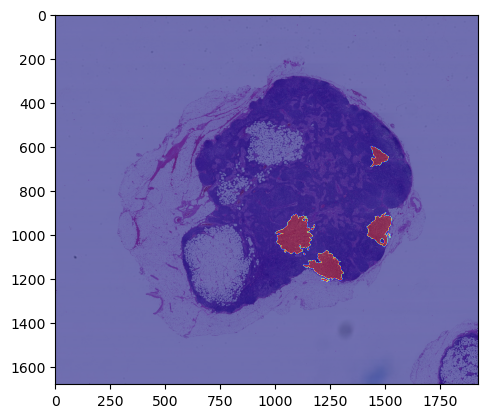

In [50]:
plt.imshow(slide_image)
plt.imshow(tumor, cmap='jet', alpha=0.5)
fig.tight_layout()


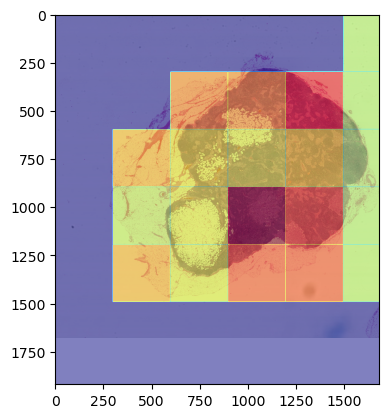

In [51]:
# Get the dimensions of the original image
import matplotlib as mpl

maglevel = 5
totalWidth, totalHt = slide.level_dimensions[maglevel]

# Create heatmap
heatmap = np.zeros((totalWidth, totalHt), dtype=float)

# Set probabilities values to specific indexes in the heatmap
for x,y,prob in maskLevel5:
    heatmap[x:x+298,y:y+298] = prob

# Plot images


plt.imshow(slide_image, vmin=0, vmax=1)
plt.imshow(heatmap, alpha=.5, cmap='jet')


fig.tight_layout()
plt.show()
            
        
        
        
    


Analysis areas with more red in it denote higher cancerous region

### Magnification level 2

In [56]:
maglevel = 2
totalWidth, totalHt = slide.level_dimensions[maglevel]
windowHt , windowWidth = 299,299
maskLevel2 = [] # will store (x,y,prob) x,y inidces of patch , while prob is the prob it is cancer 
groundTruthLevel2 = []
for x in range(0,totalHt-windowHt,windowHt):
    for y in range(0,totalWidth-windowWidth,windowWidth):

        scaleTempx,scaleTempy = int(x*slide.level_downsamples[maglevel]), int(y*slide.level_downsamples[maglevel])
        slideImage = read_slide(slide, 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)
        #print(slideImage.shape)
        tumor =  read_slide(tumor_mask , 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)[:,:,0]
        #print(slideImage.shape)
        if not containsTissue(slideImage):
            continue
        indicator = np.max(tumor)
        groundTruthLevel2.append((x,y,indicator))

        # getting prob for the class
        levelProb = magLevelClassifer.predict(tf.expand_dims(slideImage,axis =0),verbose=0)[0]
        netProb = 0
        #print(levelProb)
        slideImage = tf.cast(tf.expand_dims(slideImage,axis =0),tf.float32)/255.0

        for level in range(4):
            if level == 0:
                prob = level1Classfier.predict(slideImage,verbose=0)[0]
                #print(prob)
                netProb += prob[1] * levelProb[level]
            elif level == 1:
                prob = level2Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            elif level == 2:
                prob = level5Classifer.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            else:
                prob = level6Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
        
        netProb = netProb
        maskLevel2.append((x,y,netProb))

In [57]:
np.save(os.path.join(SlideResult,"groundTruthLevel2"),np.asarray(groundTruthLevel2))
np.save(os.path.join(SlideResult,"predictLevel2"),np.asarray(maskLevel2))

In [61]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=slide.level_dimensions[2][0], 
                         height=slide.level_dimensions[2][1])
tumor = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=tumor_mask.level_dimensions[2][0], 
                         height=tumor_mask.level_dimensions[2][1])[:,:,0]

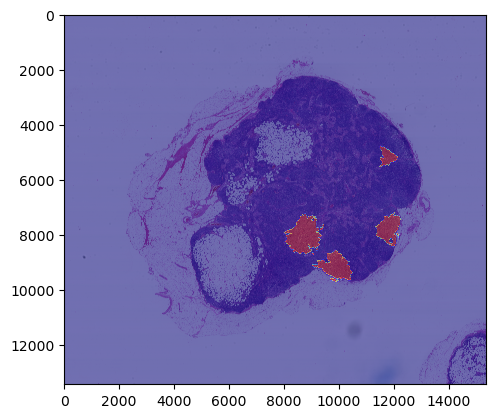

In [62]:
plt.imshow(slide_image)
plt.imshow(tumor, cmap='jet', alpha=0.5)
fig.tight_layout()

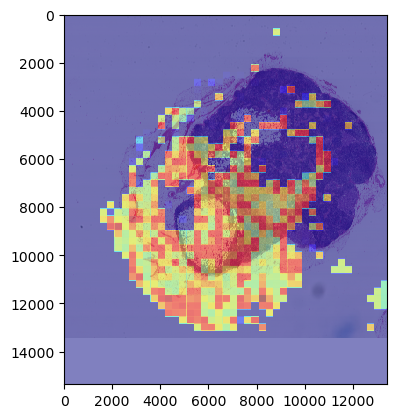

In [64]:
import matplotlib as mpl

maglevel = 2
totalWidth, totalHt = slide.level_dimensions[maglevel]

# Create heatmap
heatmap = np.zeros((totalWidth, totalHt), dtype=float)

# Set probabilities values to specific indexes in the heatmap
for x,y,prob in maskLevel2:
    heatmap[x:x+298,y:y+298] = prob

# Plot images


plt.imshow(slide_image, vmin=0, vmax=1)
plt.imshow(heatmap, alpha=.5, cmap='jet')


fig.tight_layout()
plt.show()
            

### Testing with another slide

In [79]:
slide_path = 'tumor_075.tif' # only this file is available
tumor_mask_path = 'tumor_075_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/slides/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/slides/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  893M  100  893M    0     0  22.3M      0  0:00:40  0:00:40 --:--:-- 23.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.4M  100 31.4M    0     0  10.9M      0  0:00:02  0:00:02 --:--:-- 10.9M


In [93]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256


#### Magnification Level 5

In [94]:
maglevel = 5
totalWidth, totalHt = slide.level_dimensions[maglevel]
windowHt , windowWidth = 299,299
maskLevel5 = [] # will store (x,y,prob) x,y inidces of patch , while prob is the prob it is cancer 
groundTruthLevel5 = [] 
for x in range(0,totalHt-windowHt,windowHt):
    for y in range(0,totalWidth-windowWidth,windowWidth):

        scaleTempx,scaleTempy = int(x*slide.level_downsamples[maglevel]), int(y*slide.level_downsamples[maglevel])
        slideImage = read_slide(slide, 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)
        
        tumor =  read_slide(tumor_mask , 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)[:,:,0]
        #print(slideImage.shape)
        if not containsTissue(slideImage):
            continue
        indicator = np.max(tumor)
        groundTruthLevel5.append((x,y,indicator))
        # getting prob for the class
        levelProb = magLevelClassifer.predict(tf.expand_dims(slideImage,axis =0),verbose=0)[0]
        netProb = 0
        #print(levelProb)
        slideImage = tf.cast(tf.expand_dims(slideImage,axis =0),tf.float32)/255.0

        for level in range(4):
            if level == 0:
                prob = level1Classfier.predict(slideImage,verbose=0)[0]
                #print(prob)
                netProb += prob[1] * levelProb[level]
            elif level == 1:
                prob = level2Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            elif level == 2:
                prob = level5Classifer.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            else:
                prob = level6Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
        
        netProb = netProb
        maskLevel5.append((x,y,netProb))

In [95]:
resultDir  ="./Results/"
if not os.path.exists(resultDir):
    os.mkdir(resultDir)

In [96]:
SlideResult = os.path.join(resultDir,"tumor_075")
if not os.path.exists(SlideResult):
    os.mkdir(SlideResult)

In [97]:
np.save(os.path.join(SlideResult,"groundTruthLevel5"),np.asarray(groundTruthLevel5))
np.save(os.path.join(SlideResult,"predictLevel5"),np.asarray(maskLevel5))

In [98]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])
tumor = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask.level_dimensions[5][0], 
                         height=tumor_mask.level_dimensions[5][1])[:,:,0]

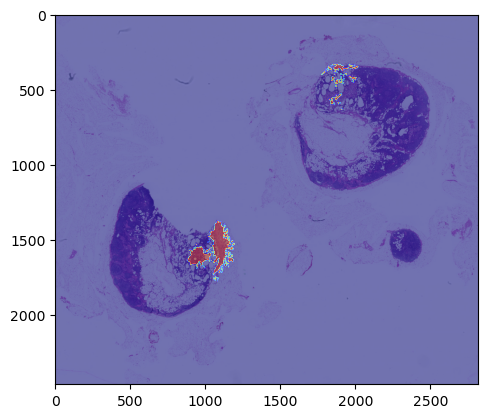

In [99]:
plt.imshow(slide_image)
plt.imshow(tumor, cmap='jet', alpha=0.5)
fig.tight_layout()

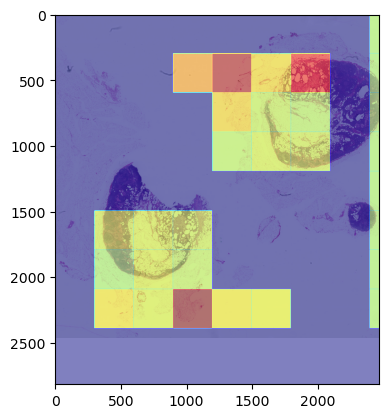

In [100]:
import matplotlib as mpl

maglevel = 5
totalWidth, totalHt = slide.level_dimensions[maglevel]

# Create heatmap
heatmap = np.zeros((totalWidth, totalHt), dtype=float)

# Set probabilities values to specific indexes in the heatmap
for x,y,prob in maskLevel5:
    heatmap[x:x+298,y:y+298] = prob

# Plot images


plt.imshow(slide_image, vmin=0, vmax=1)
plt.imshow(heatmap, alpha=.5, cmap='jet')


fig.tight_layout()
plt.show()

#### Magnification Level 2

In [101]:
maglevel = 2
totalWidth, totalHt = slide.level_dimensions[maglevel]
windowHt , windowWidth = 299,299
maskLevel2 = [] # will store (x,y,prob) x,y inidces of patch , while prob is the prob it is cancer 
groundTruthLevel2 = []
for x in range(0,totalHt-windowHt,windowHt):
    for y in range(0,totalWidth-windowWidth,windowWidth):

        scaleTempx,scaleTempy = int(x*slide.level_downsamples[maglevel]), int(y*slide.level_downsamples[maglevel])
        slideImage = read_slide(slide, 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)
        #print(slideImage.shape)
        tumor =  read_slide(tumor_mask , 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)[:,:,0]
        #print(slideImage.shape)
        if not containsTissue(slideImage):
            continue
        indicator = np.max(tumor)
        groundTruthLevel2.append((x,y,indicator))

        # getting prob for the class
        levelProb = magLevelClassifer.predict(tf.expand_dims(slideImage,axis =0),verbose=0)[0]
        netProb = 0
        #print(levelProb)
        slideImage = tf.cast(tf.expand_dims(slideImage,axis =0),tf.float32)/255.0

        for level in range(4):
            if level == 0:
                prob = level1Classfier.predict(slideImage,verbose=0)[0]
                #print(prob)
                netProb += prob[1] * levelProb[level]
            elif level == 1:
                prob = level2Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            elif level == 2:
                prob = level5Classifer.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
            else:
                prob = level6Classfier.predict(slideImage,verbose=0)[0]
                netProb += prob[1] * levelProb[level]
        
        netProb = netProb
        maskLevel2.append((x,y,netProb))

In [102]:
np.save(os.path.join(SlideResult,"groundTruthLevel2"),np.asarray(groundTruthLevel2))
np.save(os.path.join(SlideResult,"predictLevel2"),np.asarray(maskLevel2))

In [103]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=slide.level_dimensions[2][0], 
                         height=slide.level_dimensions[2][1])
tumor = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=tumor_mask.level_dimensions[2][0], 
                         height=tumor_mask.level_dimensions[2][1])[:,:,0]

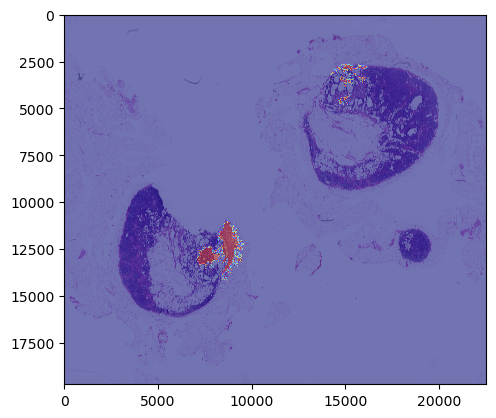

In [104]:
plt.imshow(slide_image)
plt.imshow(tumor, cmap='jet', alpha=0.5)
fig.tight_layout()

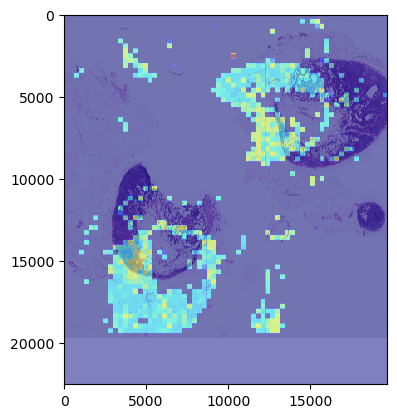

In [105]:
import matplotlib as mpl

maglevel = 2
totalWidth, totalHt = slide.level_dimensions[maglevel]

# Create heatmap
heatmap = np.zeros((totalWidth, totalHt), dtype=float)

# Set probabilities values to specific indexes in the heatmap
for x,y,prob in maskLevel2:
    heatmap[x:x+298,y:y+298] = prob

# Plot images


plt.imshow(slide_image, vmin=0, vmax=1)
plt.imshow(heatmap, alpha=.5, cmap='jet')


fig.tight_layout()
plt.show()

### Calculating Metrics

##### For Slide tumor_091

##### Magnification level 5

In [198]:
resultsPath = './Results'
slideName = 'tumor_091'

In [199]:
groundTruthLevel5 = np.load(os.path.join(resultsPath,slideName,'groundTruthLevel5.npy'))[:,2]
predict5 = np.load(os.path.join(resultsPath,slideName,'predictLevel5.npy'))[:,2]

In [218]:
from sklearn.metrics import precision_recall_fscore_support
def computeMetrics(groundTruthLevel5,predict5):
    predict5 = np.where(predict5 >= 0.120,1,0)
    #groundTruthLevel5,predict5 = list(groundTruthLevel5), list(predict5)
    return precision_recall_fscore_support(groundTruthLevel5.transpose(),predict5.transpose())
    

In [219]:
precision,recall,fscore,supp = computeMetrics(groundTruthLevel5,predict5)
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.9 0.3]
Recall: [0.5625 0.75  ]
F1 Score: [0.69230769 0.42857143]


##### Magnification level 2

In [220]:
groundTruthLevel2 = np.load(os.path.join(resultsPath,slideName,'groundTruthLevel2.npy'))[:,2]
predict2 = np.load(os.path.join(resultsPath,slideName,'predictLevel2.npy'))[:,2]

In [221]:
precision,recall,fscore,supp = computeMetrics(groundTruthLevel2,predict2)
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.97592295 0.15071283]
Recall: [0.74464176 0.71153846]
F1 Score: [0.84473776 0.2487395 ]


#### For Slide tumor_075

##### For Magnification Level 2

In [222]:
resultsPath = './Results'
slideName = 'tumor_075'

In [223]:
groundTruthLevel5_2 = np.load(os.path.join(resultsPath,slideName,'groundTruthLevel5.npy'))[:,2]
predict5_2 = np.load(os.path.join(resultsPath,slideName,'predictLevel5.npy'))[:,2]

In [226]:
precision,recall,fscore,supp = computeMetrics(groundTruthLevel5_2,predict5_2)
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.81818182 0.22222222]
Recall: [0.39130435 0.66666667]
F1 Score: [0.52941176 0.33333333]


In [227]:
groundTruthLevel2_2 = np.load(os.path.join(resultsPath,slideName,'groundTruthLevel2.npy'))[:,2]
predict2_2 = np.load(os.path.join(resultsPath,slideName,'predictLevel2.npy'))[:,2]

In [232]:
precision,recall,fscore,supp = computeMetrics(groundTruthLevel2_2,predict2_2)
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.97592295 0.15071283]
Recall: [0.74464176 0.71153846]
F1 Score: [0.84473776 0.2487395 ]


#### Metrics using both slides

#### Magnification Level 2

In [239]:
precision,recall,fscore,supp = computeMetrics(np.append(groundTruthLevel2,groundTruthLevel2_2),np.append(predict2,predict2_2))
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.97592295 0.15071283]
Recall: [0.74464176 0.71153846]
F1 Score: [0.84473776 0.2487395 ]


#### Magnification level 5

In [241]:
precision,recall,fscore,supp = computeMetrics(np.append(groundTruthLevel5,groundTruthLevel5_2),np.append(predict5,predict5_2))
print("Precision:",precision )
print("Recall:",recall )
print("F1 Score:",fscore )

Precision: [0.85714286 0.25      ]
Recall: [0.46153846 0.7       ]
F1 Score: [0.6        0.36842105]
